In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load the RFM data we created earlier
rfm = pd.read_csv('../data/processed/customer_rfm.csv', index_col=0)

print("Data loaded!")
print(f"Total customers: {len(rfm)}")
print("\nFirst few rows:")
print(rfm.head())

Data loaded!
Total customers: 98666

First few rows:
                                  recency  frequency  monetary  R_score   
customer_id                                                               
00012a2ce6f8dcda20d059ce98491703      292          1     89.80        2  \
000161a058600d5901f007fab4c27140      413          1     54.90        1   
0001fd6190edaaf884bcaf3d49edf079      551          1    179.99        1   
0002414f95344307404f0ace7a26f1d5      382          1    149.90        1   
000379cdec625522490c315e70c7a9fb      153          1     93.00        3   

                                  F_score  M_score  RFM_score        segment  
customer_id                                                                   
00012a2ce6f8dcda20d059ce98491703        1        3        213           Lost  
000161a058600d5901f007fab4c27140        1        2        112           Lost  
0001fd6190edaaf884bcaf3d49edf079        1        4        114   Big Spenders  
0002414f95344307404f0ace7a

Customers who churned (>180 days): 60091
Active customers: 38575
Churn rate: 60.9%


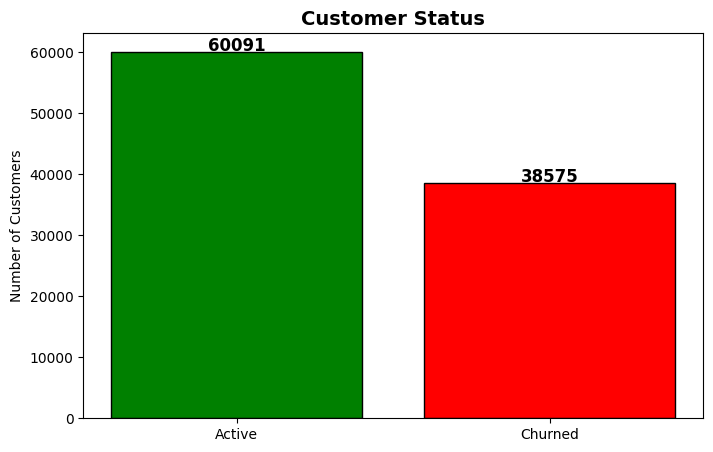

In [3]:
# Let's say a customer has "churned" if they haven't bought anything in 180+ days
CHURN_THRESHOLD = 180

# Create a new column: 1 = churned, 0 = active
rfm['churned'] = (rfm['recency'] > CHURN_THRESHOLD).astype(int)

print(f"Customers who churned (>{CHURN_THRESHOLD} days): {rfm['churned'].sum()}")
print(f"Active customers: {len(rfm) - rfm['churned'].sum()}")
print(f"Churn rate: {rfm['churned'].mean() * 100:.1f}%")

# Visualize
plt.figure(figsize=(8, 5))
churn_counts = rfm['churned'].value_counts()
plt.bar(['Active', 'Churned'], churn_counts.values, color=['green', 'red'], edgecolor='black')
plt.title('Customer Status', fontsize=14, fontweight='bold')
plt.ylabel('Number of Customers')
for i, v in enumerate(churn_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontsize=12, fontweight='bold')
plt.show()

In [5]:
# Features = the information we'll use to predict churn
# We'll use: recency, frequency, monetary

# First, let's see if there are any missing values
print("Missing values:")
print(rfm.isnull().sum())

# Select only the columns we need
features = rfm[['recency', 'frequency', 'monetary']].copy()
target = rfm['churned'].copy()

print("\nFeatures shape:", features.shape)
print("Target shape:", target.shape)

# Look at the features
print("\nFeature statistics:")
print(features.describe())

Missing values:
recency      0
frequency    0
monetary     0
R_score      0
F_score      0
M_score      0
RFM_score    0
segment      0
churned      0
dtype: int64

Features shape: (98666, 3)
Target shape: (98666,)

Feature statistics:
            recency  frequency      monetary
count  98666.000000    98666.0  98666.000000
mean     244.815803        1.0    137.754076
std      153.392909        0.0    210.645145
min        0.000000        1.0      0.850000
25%      121.000000        1.0     45.900000
50%      226.000000        1.0     86.900000
75%      355.000000        1.0    149.900000
max      728.000000        1.0  13440.000000


In [6]:
# We need to split our data:
# - Training set (80%): The model learns from this
# - Testing set (20%): We test the model on this (it hasn't seen it before)

X_train, X_test, y_train, y_test = train_test_split(
    features,           # X = features (inputs)
    target,             # y = target (what we're predicting)
    test_size=0.2,      # 20% for testing
    random_state=42     # This makes results reproducible
)

print(f"Training set size: {len(X_train)} customers")
print(f"Testing set size: {len(X_test)} customers")
print(f"\nChurned in training set: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Churned in testing set: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Training set size: 78932 customers
Testing set size: 19734 customers

Churned in training set: 48092 (60.9%)
Churned in testing set: 11999 (60.8%)


In [7]:
# Create a Random Forest model
# Random Forest = a collection of decision trees that vote on the prediction
model = RandomForestClassifier(
    n_estimators=100,    # Use 100 trees
    random_state=42,     # For reproducibility
    max_depth=10         # How deep each tree can grow
)

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Training complete! ✅")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churning

print(f"\nPredictions made on {len(X_test)} customers")

Training the model...
Training complete! ✅

Predictions made on 19734 customers


In [8]:
# How accurate is the model?
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.1f}%")

# More detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

# ROC-AUC Score (0.5 = random guessing, 1.0 = perfect)
roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_score:.3f}")

Accuracy: 100.0%

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00      7735
     Churned       1.00      1.00      1.00     11999

    accuracy                           1.00     19734
   macro avg       1.00      1.00      1.00     19734
weighted avg       1.00      1.00      1.00     19734


ROC-AUC Score: 1.000


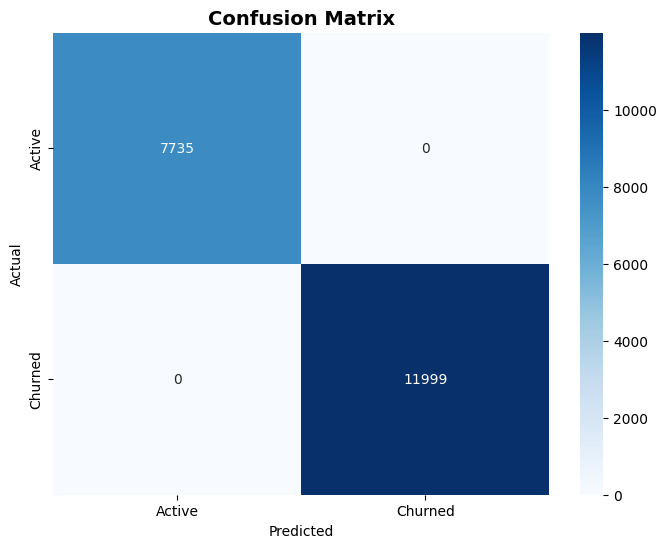


Confusion Matrix Explanation:
True Negatives (correctly predicted active): 7735
False Positives (predicted churn, but active): 0
False Negatives (predicted active, but churned): 0
True Positives (correctly predicted churn): 11999


In [9]:
# Confusion Matrix shows where the model is making mistakes
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Explain the numbers
print("\nConfusion Matrix Explanation:")
print(f"True Negatives (correctly predicted active): {cm[0,0]}")
print(f"False Positives (predicted churn, but active): {cm[0,1]}")
print(f"False Negatives (predicted active, but churned): {cm[1,0]}")
print(f"True Positives (correctly predicted churn): {cm[1,1]}")

Feature Importance:
     feature  importance
0    recency    0.998589
2   monetary    0.001411
1  frequency    0.000000


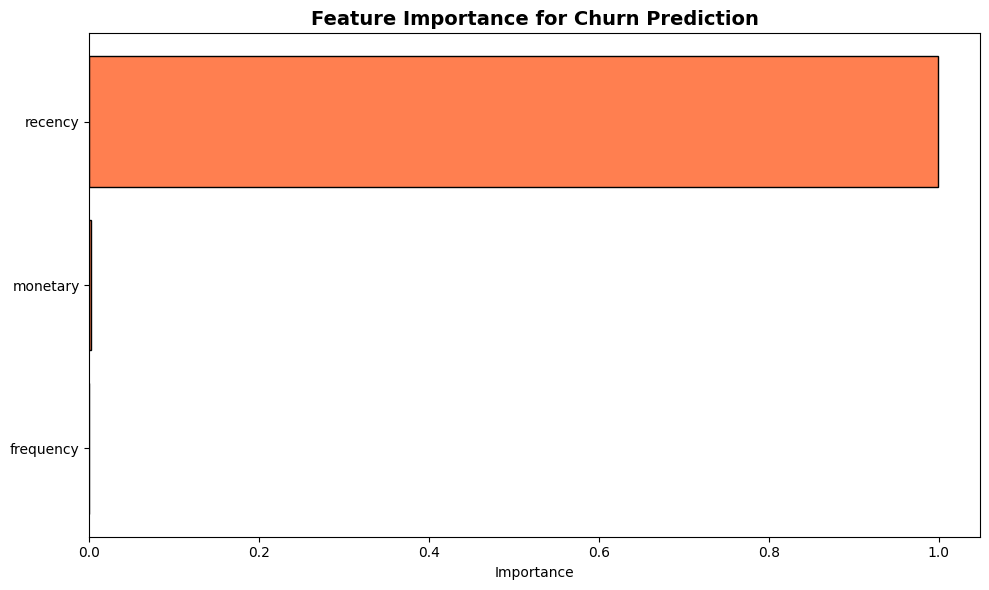

In [10]:
# Which features are most important for predicting churn?
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

In [11]:
# Let's predict churn risk for all customers and add it to our data
rfm['churn_probability'] = model.predict_proba(rfm[['recency', 'frequency', 'monetary']])[:, 1]
rfm['churn_risk'] = pd.cut(rfm['churn_probability'], 
                            bins=[0, 0.3, 0.7, 1.0], 
                            labels=['Low', 'Medium', 'High'])

print("Customers by churn risk:")
print(rfm['churn_risk'].value_counts())

# Show high-risk customers
print("\nTop 10 highest risk customers:")
high_risk = rfm.nlargest(10, 'churn_probability')[['recency', 'frequency', 'monetary', 
                                                     'segment', 'churn_probability']]
print(high_risk)

# Save the updated data
rfm.to_csv('../data/processed/customer_rfm_with_predictions.csv')
print("\nPredictions saved!")

Customers by churn risk:
churn_risk
High      60091
Low         792
Medium        0
Name: count, dtype: int64

Top 10 highest risk customers:
                                  recency  frequency  monetary        segment   
customer_id                                                                     
00012a2ce6f8dcda20d059ce98491703      292          1     89.80           Lost  \
000161a058600d5901f007fab4c27140      413          1     54.90           Lost   
0001fd6190edaaf884bcaf3d49edf079      551          1    179.99   Big Spenders   
0002414f95344307404f0ace7a26f1d5      382          1    149.90           Lost   
0004164d20a9e969af783496f3408652      509          1     59.99           Lost   
000419c5494106c306a97b5635748086      184          1     34.30  New Customers   
00046a560d407e99b969756e0b10f282      258          1    120.90           Lost   
00050bf6e01e69d5c0fd612f1bcfb69c      350          1     69.99           Lost   
00062b33cb9f6fe976afdcff967ea74d      536       